# hex adapter demo

*<<< check out other demo models [here](https://github.com/FullControlXYZ/fullcontrol/tree/master/models/README.md) >>>*
  
run all cells in this notebook, or press shift+enter to run each cell sequentially 

if you change one of the code cells, make sure you run it and all subsequent cells again (in order)

*this document is a jupyter notebook - if they're new to you, check out how they work: [link](https://www.google.com/search?q=ipynb+tutorial), [link](https://jupyter.org/try-jupyter/retro/notebooks/?path=notebooks/Intro.ipynb), [link](https://colab.research.google.com/)*

In [1]:
import fullcontrol as fc
from math import tau
from copy import deepcopy

In [2]:
# printer/gcode parameters

design_name = 'hex_adapter'
nozzle_temp = 210
bed_temp = 40
print_speed = 1000
fan_percent = 100
printer_name='prusa_i3' # generic / ultimaker2plus / prusa_i3 / ender_3 / cr_10 / bambulab_x1 / toolchanger_T0

In [3]:
# design parameters

inner_size = 10
# Inner Hex (mm) - Size of hexagonal hole (space between two opposing inner hexagon walls)
# default value: 10 

outer_size = 16
# Outer Hex (mm) - Size of outer hexagonal shape (distance between outer edges of two opposing outer hexagon walls)
# default value: 16 

height = 4
# Thickness (mm) - Thickness of the adapter
# default value: 4

inner_oversize = 0.2
# Inner Hex Oversize (mm) - This can be used to finely adjust the size of the inner hexagon (positive value makes hole bigger)
# default value: 0.2

outer_undersize = 0.2
# Outer Hex Undersize (mm) - This can be used to finely adjust the size of the outer hexagon (positive value makes part smaller)
# default value: 0.2

EW = 0.6
# Extrusion Width (mm) - Width of printed lines - recommended value: 1.5x nozzle diameter
# default value: 0.6

EH = 0.2
# Extrusion Height (mm) - Height of printed lines (i.e. layer thickness) - recommended value: 0.5x nozzle diameter
# default value: 0.2

quantity = 1
# Quantity - Number of parts to print
# default value: 1 ; guideline range: 1 to 5

multipart_offset_x = 0
# Multipart Offset X (mm) - Space between parts in X direction when quantity > 1
# default value: 0 

multipart_offset_y = 40
# Multipart Offset Y (mm) - Space between parts in Y direction when quantity > 1
# default value: 40



In [4]:
# generate the design (make sure you've run the above cells before running this cell)


layers = int(height/EH)
inner_size += EW/2 
outer_size -= EW/2 

r_hex_inner = (inner_size/2)*(2/(3**0.5)) + inner_oversize
r_hex_outer = (outer_size/2)*(2/(3**0.5)) - outer_undersize

centre = fc.Point(x=0,y=0,z=0)

hex_outer = fc.polygonXY(centre, r_hex_outer, tau/2, 6, cw=False)
hex_inner = fc.polygonXY(centre, r_hex_inner, tau/2, 6, cw=False)

hex_unit = []
hex_unit.append(hex_outer[0])
hex_unit.append(fc.midpoint(hex_outer[0],hex_outer[5]))
hex_unit.append(hex_inner[0])
hex_unit.append(hex_inner[1])
hex_unit.append(fc.midpoint(hex_outer[1],hex_outer[2]))
hex_unit.append(hex_outer[1])

steps_one_layer = []
for i in range(6):
  rotation=i*(tau/6)
  steps_one_layer += fc.move_polar(hex_unit,centre,0,rotation)
  
steps_multilayer = fc.move(steps_one_layer, fc.Vector(z=EH), True, layers)

if quantity > 1:
    # need deepcopy since we refer to steplist_multilayer in every loop and don't want to modify it
    steps_array = deepcopy(steps_multilayer)
    prime_radius = r_hex_outer+5*EW
    for i in range(quantity-1):
        centre_now = fc.Point(x=centre.x+multipart_offset_x*(i+1), y=centre.y+multipart_offset_y*(i+1))
        # move to new start point without extrusion
        steps_array.append(fc.Extruder(on=False))
        steps_array.append(fc.Point(z=height+1))
        # begin outside the primer circle to keep polymer drool away from the part
        steps_array.append(fc.Point(x=centre_now.x-prime_radius-5, y=centre_now.y))
        steps_array.append(fc.Point(z=0))
        # print a circle to get flow going
        steps_array.append(fc.Extruder(on=True))
        steps_array.extend(fc.circleXY(centre_now,prime_radius,tau/2,32))
        steps_array.extend(fc.move(steps_multilayer, fc.Vector(x=multipart_offset_x*(i+1),y=multipart_offset_y*(i+1))))
    steps_multilayer = steps_array

# offset the whole procedure. z dictates the gap between the nozzle and the bed for the first layer, assuming the model was designed with a first layer z-position of 0
model_offset = fc.Vector(x=30, y=30, z=0.8*EH)
steps = fc.move(steps_multilayer, model_offset)

<Figure size 640x480 with 0 Axes>

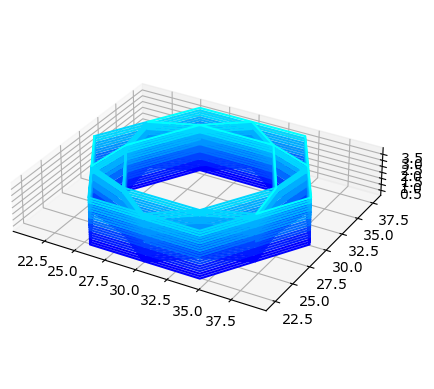

In [7]:
# preview the design

# fc.transform(steps, 'plot', fc.PlotControls(style='line'))
# hover the cursor over the lines in the plot to check xyz positions of the points in the design

# uncomment the next line to create a plot with real heights/widths for extruded lines to preview the real 3D printed geometry
fc.transform(steps, 'plot', fc.PlotControls(zoom=0.7, style='line', initialization_data={'extrusion_width': EW, 'extrusion_height': EH}))

# uncomment the next line to create a neat preview (click the top-left button in the plot for a .png file) - post and tag @FullControlXYZ :)
# fc.transform(steps, 'plot', fc.PlotControls(neat_for_publishing=True, zoom=0.7,  initialization_data={'extrusion_width': EW, 'extrusion_height': EH}))


In [6]:
# generate and save gcode

gcode_controls = fc.GcodeControls(
    printer_name=printer_name,
    save_as=design_name,
    initialization_data={
        'primer': 'front_lines_then_y',
        'print_speed': print_speed,
        'nozzle_temp': nozzle_temp,
        'bed_temp': bed_temp,
        'fan_percent': fan_percent,
        'extrusion_width': EW,
        'extrusion_height': EH})
gcode = fc.transform(steps, 'gcode', gcode_controls)

#### please tell us what you're doing with FullControl!

- tag FullControlXYZ on social media ([twitter](https://twitter.com/FullControlXYZ), [instagram](https://www.instagram.com/fullcontrolxyz/), [linkedin](https://www.linkedin.com/in/andrew-gleadall-068587119/), [tiktok](https://www.tiktok.com/@fullcontrolxyz))
- email [info@fullcontrol.xyz](mailto:info@fullcontrol.xyz)
- post on the [subreddit](https://reddit.com/r/fullcontrol)
- post in the [github discussions or issues tabs](https://github.com/FullControlXYZ/fullcontrol/issues)

in publications, please cite the original FullControl paper and the github repo for the new python version:

- Gleadall, A. (2021). FullControl GCode Designer: open-source software for unconstrained design in additive manufacturing. Additive Manufacturing, 46, 102109. 
- Gleadall, A. and Leas, D. (2023). FullControl [electronic resource: python source code]. available at: https://github.com/FullControlXYZ/fullcontrol